In [1]:
# change main root dir
%cd ..\..

D:\Projects\CondaAnalyses\PMI


In [2]:
import os
import gc
import numpy as np
import pandas as pd
import geopy
import geopandas as gpd
import seaborn as sns
import math
import random
from random import randint
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import folium
import utilities
from functools import reduce

In [20]:
data_path = 'data_checkpoints/usecase_cab/'
flatui = ["#9225a5", "#82c7a5", "#0145ac", "#eece1a", "#f4d6ad", "#f15e22"]
sns.set_style(
    "darkgrid",
    {

        "grid.linestyle": ":",
        'axes.facecolor':'#1B212C'
    }
)
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

# PMI Technical Challenge: San Francisco Taxi Cabs
***

## Introduction
This technical challenge is part one of two assessment challenges for the Data Science Lead position.

For this data science challenge, a dataset containing mobility traces of ~500 taxi cabs collected over ~30 days in San Fracisco is provided.  
The data can be obtained from: __[rvi_big_data](https://github.com/PDXostc/rvi_big_data/blob/master/cabspottingdata.tar.g)__

The format of each mobility trace file is the following - each line contains:  
`[latitude, longitude, occupancy, time]`  
Example:  
`[[37.75134 -122.39488 01213084687]`

Where:  
latitude and logitude are decimal degrees  
occupancy shows if cab has a fare (1=occupied, 0=free)  
time is in UNIX epoch format.  

**The goal of this data science challenge is to calculate the potential for a yearly reduction in CO2
emissions, caused by the taxi cabs roaming without passengers.**   
In your calculation please assume that the taxicab fleet is changing at the rate of 15% per month (from combustion engine-powered vehicles to electric vehicles).  
Assume also that the average passenger vehicle emits about 404 grams of CO2 per mile. 

Bonus question: **To build a predictor for taxi drivers, predicting the next place a passenger will hail a
cab.**

## Sections

[Initial Exploratory Analysis](#Initial-Exploratory-Data-Analysis)  
[Location Analysis](#Location-Analysis)  
[Event Duration Analysis](#Event-Duration-Analysis)  
[Distance Analysis](#Distance-Analysis)  

## Answers
[Calculate potential yearly reduction in CO2 emissions of cabs without passengers](#CO2-Savings)  
__[Next Fare Predictor](http://localhost:8888/notebooks/PMI/notebooks/cabspotting/Next%20Fare%20Predictor.ipynb#Next-Fare-Predictor)__

## Initial Dataframe
***
### Creating a base Dataframe

Different jupyter notebooks have been created to keep a **Separation of Concerns** approach for different features of the dataset.  

This helps by **reducing the computation** and **RAM payloads** and **enables** better **maintainability and extendibility** of our code and datasets.  
Every transformation can be found in the `./transforms/` directory.  

Also, a separate utilities module has been implemented to abstract complex transformations and provide a cleaner code structure. It might be possible to implement this utilities module as a separate package if the solution needs to be industrialized. Since this is an assessment project, it is kept as a separate module and not a package.

In [ ]:
## commented out because initial_merge.csv was created
# import dataframes
# base_df = pd.read_csv(data_path+'base_df.csv', index_col=0)

# occupancy_df = pd.read_csv(data_path+'occupancy_state_change.csv', index_col=0)

# travelled_distance_df = pd.read_csv(data_path+'travelled_distance.csv', index_col=0)

# event_duration_df = pd.read_csv(data_path+'event_duration.csv', index_col=0)

# dfs = [base_df, occupancy_df, travelled_distance_df, event_duration_df]

# # merge dataframes
# df = reduce(lambda  left,right:
#             pd.merge(left, right, on=['id']),
#             dfs)

# # Keep RAM happy
# del base_df, occupancy_df, travelled_distance_df
# gc.collect()

# df['time']= pd.to_datetime(df['time'])
# df.head()

In [4]:
df =  pd.read_csv(data_path+'initial_merge.csv', index_col=0)
df['time']= pd.to_datetime(df['time'])
print(f"There are {len(df.id_event.unique())} unique event ids")
df.tail()

There are 928307 unique event ids


,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration
11220053,uvreoipy_1213035491,uvreoipy,37.74654,-122.44338,2008-06-09 18:18:11,1,uvreoipy_1213035433,1.863837,296.0
11220054,uvreoipy_1213035548,uvreoipy,37.75140,-122.44296,2008-06-09 18:19:08,1,uvreoipy_1213035433,1.863837,296.0
11220055,uvreoipy_1213035612,uvreoipy,37.75686,-122.44239,2008-06-09 18:20:12,1,uvreoipy_1213035433,1.863837,296.0
11220056,uvreoipy_1213035668,uvreoipy,37.76047,-122.44215,2008-06-09 18:21:08,1,uvreoipy_1213035433,1.863837,296.0
11220057,uvreoipy_1213035729,uvreoipy,37.76075,-122.43687,2008-06-09 18:22:09,1,uvreoipy_1213035433,1.863837,296.0


## Initial Exploratory Data Analysis
***
We begin by exploring the following points:
- No. of files in scope
- Timeframe of data collection
- No. of initial Observations
- No. of events (change of occupancy state)
- No. of events without occupancy
- No. of events with occupancy

In [5]:
# No. of files in scope
no_cab_file = df['file_name'].nunique()
print(f'The number of cab files in the dataset is: {no_cab_file}')

# Time frame
start_time_datapoint = df.time.min()
end_time_datapoint = df.time.max()
total_time_datapoint = end_time_datapoint - start_time_datapoint
print(f'Data was collected between {str(start_time_datapoint)} and {str(end_time_datapoint)}')
print(f'Time-frame is {str(total_time_datapoint)}')
print(f'Time-frame is {str(total_time_datapoint.total_seconds())} \
seconds or {str(total_time_datapoint.total_seconds()/60/60)} hours')

# No. of initial observations
print(f'There are {df.id.count()} observations in the initial dataset')

# No. of events
print(f'Total number of events: {len(df.id_event.unique())}')

# No. of events without occupancy
occupied_cab_events = len(df[df.occupancy == 1].id_event.unique())
print(f'Total number of trips with passengers: {occupied_cab_events}')

# No. of events with occupancy
unnocupied_cab_events = len(df[df.occupancy == 0].id_event.unique())
print(f'Total number of trips without passengers: {unnocupied_cab_events}')

The number of cab files in the dataset is: 537
Data was collected between 2008-05-17 10:00:04 and 2008-06-10 09:25:34
Time-frame is 23 days 23:25:30
Time-frame is 2071530.0 seconds or 575.425 hours
There are 11220058 observations in the initial dataset
Total number of events: 928307
Total number of trips with passengers: 464048
Total number of trips without passengers: 464259


⚠️ Only ~24 days have been collected. Further scaling needed to analyze a month's to fit requirements.

## Location Analysis
***
An analysis of the locations where the cabs fare is needed to assess possible outliers.  
A scatterplot diagram is used to map out all the datapoints.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

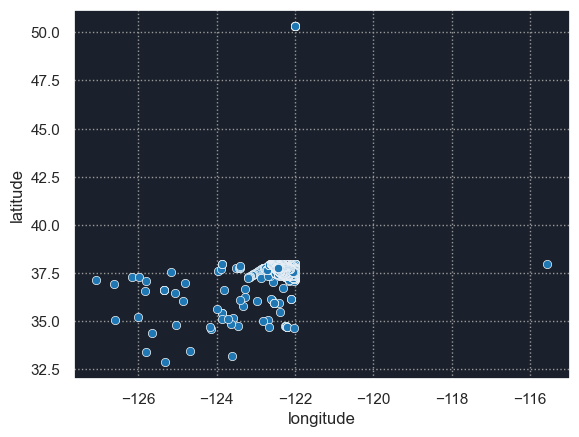

In [6]:
sns.scatterplot(x=df['longitude'], y=df['latitude'])

⚠️ **High Variance**  
From this graph a high variance is appreciated.  
Since variance is a measure of dispersion from the mean (average) values we can infer that there are a number of outliers from our dataset

To identify those outliers, **San Francisco Coordinates**<a name="LatLong"></a>[<sup>[1]</sup>](https://www.latlong.net/place/san-francisco-ca-usa-326.html)are used

| latitude | longitude |
---|---
| 37.733795 | -122.446747 |


In [7]:
SFO_COORDSINATES = 37.733795, -122.446747

In [8]:
west_outlier = df.longitude.min()
east_outlier = df.longitude.max()
north_outlier = df.latitude.max()
south_outlier = df.latitude.min()

westernmost_dataset_point = df.latitude.iloc[df.loc[df.longitude==west_outlier].index[0]], west_outlier
easternmost_dataset_point = df.latitude.iloc[df.loc[df.longitude==east_outlier].index[0]], east_outlier
northernmost_dataset_point = north_outlier, df.longitude.iloc[df.loc[df.latitude==north_outlier].index[0]]
southernmost_dataset_point = south_outlier, df.longitude.iloc[df.loc[df.latitude==south_outlier].index[0]]

print(f'Westernmost coordinate: {westernmost_dataset_point}')
print(f'Easternmost coordinate: {easternmost_dataset_point}')
print(f'Northernmost coordinate: {northernmost_dataset_point}')
print(f'Southern coordinate: {southernmost_dataset_point}')

Westernmost coordinate: (37.14853, -127.08143)
Easternmost coordinate: (37.99975, -115.56218)
Northernmost coordinate: (50.30546, -122.00204)
Southern coordinate: (32.8697, -125.32262)


In [9]:
# Show San Francisco Coordinates
map = folium.Map(location=[SFO_COORDSINATES[0], SFO_COORDSINATES[1]], zoom_start = 4)
folium.Marker([SFO_COORDSINATES[0], SFO_COORDSINATES[1]]).add_to(map)
folium.Marker(northernmost_dataset_point, icon=folium.Icon(color="red", icon="arrow-up")).add_to(map)
folium.Marker(southernmost_dataset_point, icon=folium.Icon(color="red", icon="arrow-down")).add_to(map)
folium.Marker(westernmost_dataset_point, icon=folium.Icon(color="red", icon="arrow-left")).add_to(map)
folium.Marker(easternmost_dataset_point, icon=folium.Icon(color="red", icon="arrow-right")).add_to(map)
map

By getting the extreme coordinates of the dataset we can verify that there are noticeable outliers on the dataset.
To reduce the scope of valid information and get a better idea of how to eliminate geopositional outliers

The following coordinates are used to define the limiting coordinates of the city map  
💡 Assumption - The valid cab fares for the analysis should have only travelled be between these coordinate points  
⚠️ This coordinates leave "Treasure Island" out of scope  
⚠️ Limits count as "hard coded"

cardinal point| latitude | longitude |
:-:|---|---
west| 37.779611 | -122.514945 |
east| 37.728654 | -122.357034 |
north | 37.811054 | -122.4771790 |
south | 37.7080955 | -122.465793  |

farmost cardinal value | limit  |
:-:|---|
west longitude | -122.51494 |
east longitude | -122.357034 | 
northlatitude | 37.811054 |
south latitude | 37.7080955 | 


In [10]:
limit_westernmost_point = 37.779611, -122.51494
limit_easternmost_point = 37.728654, -122.357034
limit_northernmost_point = 37.811054, -122.4771790
limit_southernmost_point = 37.7080955, -122.465793

farmost_west_longitude_point = -122.51494
farmost_east_longitude_point = -122.357034
farmost_north_latitude_point = 37.811054
farmost_south_latitude_point = 37.7080955

map = folium.Map(location=[SFO_COORDSINATES[0], SFO_COORDSINATES[1]], zoom_start = 10)
folium.Marker([SFO_COORDSINATES[0], SFO_COORDSINATES[1]]).add_to(map)
folium.Marker(limit_northernmost_point, icon=folium.Icon(color="orange", icon="arrow-down")).add_to(map)
folium.Marker(limit_southernmost_point, icon=folium.Icon(color="orange", icon="arrow-up")).add_to(map)
folium.Marker(limit_westernmost_point, icon=folium.Icon(color="orange", icon="arrow-right")).add_to(map)
folium.Marker(limit_easternmost_point, icon=folium.Icon(color="orange", icon="arrow-left")).add_to(map)
map

In [11]:
points = [limit_westernmost_point, limit_easternmost_point, limit_northernmost_point, limit_southernmost_point]
minmax_latitudes = min(points)[0], max(points)[0]
minmax_longitudes = min(points)[1], max(points)[1]
minmax_latitudes, minmax_longitudes

((37.7080955, 37.811054), (-122.465793, -122.477179))

In [12]:
outbound_events_ids = df[
    (df['longitude'] <= farmost_west_longitude_point) | 
    (df['longitude'] >= farmost_east_longitude_point) |
    (df['latitude'] <= farmost_south_latitude_point) |  
    (df['latitude'] >= farmost_north_latitude_point)
    ].id_event.unique()

In [13]:
filtered_events= df[~df.id_event.isin(outbound_events_ids)]
total_events = len(df['id_event'].unique())
valid_events = len(filtered_events['id_event'].unique())
invalid_events = total_events - valid_events
print(f'Number of fares outside of city limits is: {invalid_events}')
print(f'From {total_events} events in the dataset only {valid_events} are valid')

Number of fares outside of city limits is: 106275
From 928307 events in the dataset only 822032 are valid


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

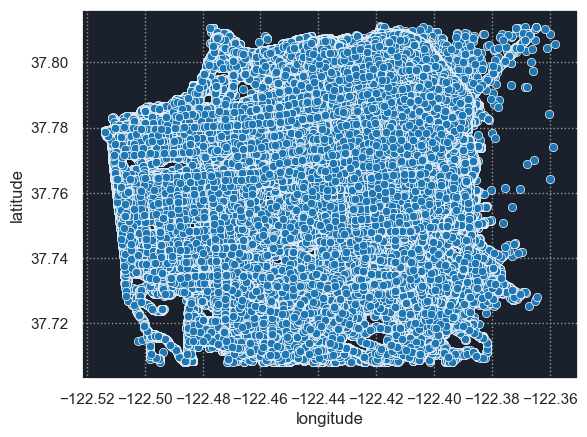

In [14]:
sns.scatterplot(x=filtered_events['longitude'], y=filtered_events['latitude'])

In [15]:
filtered_events.to_csv(data_path+'filtered_locations_df.csv')
del filtered_events
gc.collect()

65

In the graph above the cab fares roaming around city limits is well appreciated.

## Event Duration Analysis
***
For the event duration analysis first the id of events and the event duration (calculated by the "event_duration" transform process) are selected.

In [16]:
event_duration_df = (df[['id_event', 'event_duration']]
                     .groupby(['id_event'])
                     .event_duration
                     .first()
                     .to_frame())
event_duration_df.head()

,event_duration
id_event,
abboip_1211033530,2314.0
abboip_1211035870,288.0
abboip_1211036160,1315.0
abboip_1211037486,222.0
abboip_1211037710,1285.0


The values of the events duration are displayed and visually appreciated in a normal distribution diagram

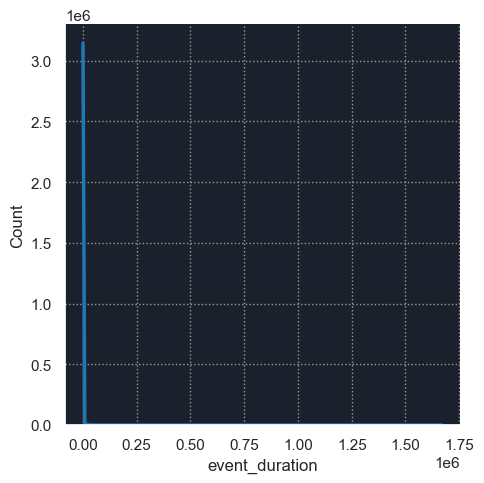

In [17]:
sns.displot(event_duration_df['event_duration'], kde=True, palette=sns.color_palette(flatui[1:2]), bins=250,)

Since the normal distribution shows an incredible dispersion, the limits are far away from most of the centered values that is, a histogram would confirm that the limits and most used values

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


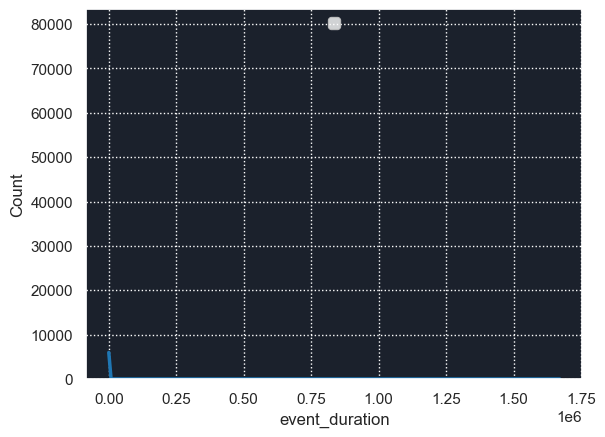

In [24]:
sns.histplot(data=event_duration_df['event_duration'], kde=True, palette=sns.color_palette(flatui[2:3]))
plt.legend(loc='upper center').get_frame().set_facecolor('white')
plt.show()

This histogram confirms that most of the events have a duration of near zero seconds. Now the minimum and maximum limits of events are analyzed.

In [25]:
print(f'Max Event Duration of empty cab (sec): {df[df.occupancy == 0.0].event_duration.max()}')
print(f'Median Event Duration of empty cab (sec): {df[df.occupancy == 0.0].event_duration.median()}')
print(f'Average Event Duration of empty cab (sec): {df[df.occupancy == 0.0].event_duration.mean()}')
print(f'Min Event Duration of empty cab (sec): {df[df.occupancy == 0.0].event_duration.min()}')
print('')
print(f'Max Event Duration of cab with passengers (sec): {df[df.occupancy == 1.0].event_duration.max()}')
print(f'Median Event Durationof cab with passengers (sec): {df[df.occupancy == 1.0].event_duration.median()}')
print(f'Average Event Durationof cab with passengers (sec): {df[df.occupancy == 1.0].event_duration.mean()}')
print(f'Min Event Duration of cab with passengers (sec): {df[df.occupancy == 1.0].event_duration.min()}')

Max Event Duration of empty cab (sec): 1670830.0
Median Event Duration of empty cab (sec): 1776.0
Average Event Duration of empty cab (sec): 10457.011111575106
Min Event Duration of empty cab (sec): 0.0

Max Event Duration of cab with passengers (sec): 119615.0
Median Event Durationof cab with passengers (sec): 733.0
Average Event Durationof cab with passengers (sec): 963.4045966052975
Min Event Duration of cab with passengers (sec): 0.0


In [26]:
percentiles = [0.05, 0.1,0.25, 0.5, 0.75, 0.9, 0.95, 1]

In [27]:
# Empty cab
(df[df.occupancy == 0.0][['id_event', 'event_duration']]
 .quantile(q=percentiles, axis=0, numeric_only=True, interpolation='linear')).T

,0.05,0.10,0.25,0.50,0.75,0.90,0.95,1.00
event_duration,179.0,305.0,728.0,1776.0,5090.0,17980.0,30414.0,1670830.0


In [28]:
# occupied cab
(df[df.occupancy == 1.0][['id_event', 'event_duration']]
 .quantile(q=percentiles, axis=0, numeric_only=True, interpolation='linear')).T

,0.05,0.10,0.25,0.50,0.75,0.90,0.95,1.00
event_duration,242.0,322.0,478.0,733.0,1129.0,1583.0,2039.0,119615.0


From these results, the following assumptions are derived using the quantiles

💡 Assumption - Unoccupied cabs 5/75  
💡 Assumption - Unoccupied cabs 5/95

occupancy | min | max |
:-:|---|---
empty | 179 sec | 5090 sec. |
occupied | 242 sec. | 2039 sec. |


In [29]:
# import the filtered_locations_df
filtered_locations_df = pd.read_csv(data_path+'filtered_locations_df.csv', index_col=0)

In [30]:
# valid data for unoccupied cabs
min_unoccupied_time_allowed = 179
max_unoccupied_time_allowed = 5090

# valid data for occupied cabs
min_occupied_time_allowed = 242
max_occupied_time_allowed = 2039

In [31]:
valid_time_fare_ids = list(
    filtered_locations_df[
        (filtered_locations_df['occupancy'] == 0)
        & filtered_locations_df['event_duration'].between(
            min_unoccupied_time_allowed,
            max_unoccupied_time_allowed,
            inclusive="both"
            )].id_event.unique()
)

valid_time_fare_ids += list(
    filtered_locations_df[
        (filtered_locations_df['occupancy'] == 1)
        & filtered_locations_df['event_duration'].between(
            min_occupied_time_allowed,
            max_occupied_time_allowed,
            inclusive="both"
            )].id_event.unique()
)

non_valid_ids_count = len(filtered_locations_df.id_event.unique()) - len(valid_time_fare_ids)

print(f'The number of valid time fares in the filtered locations df is {len(valid_time_fare_ids)}')
print(f'The number of non valid time fares in the filtered locations df is {non_valid_ids_count}')
print(f'The total number of time fares in the filtered locations df is {len(filtered_locations_df.id_event.unique())}')

The number of valid time fares in the filtered locations df is 586826
The number of non valid time fares in the filtered locations df is 235206
The total number of time fares in the filtered locations df is 822032


In [32]:
valid_df = filtered_locations_df[filtered_locations_df.id_event.isin(valid_time_fare_ids)]

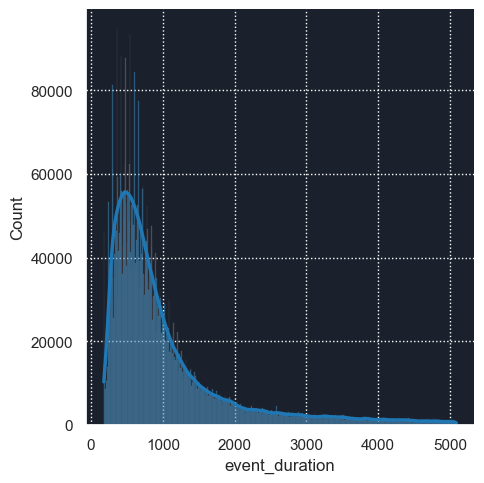

In [33]:
# Assuring data is consistent
sns.displot(valid_df['event_duration'], kde=True)

Now a more consistent distribution is noticed. Although there is still an evident dispersion it fits under our assumptions.
We now look at a scatter plot to figure out if the datapoints are still within limits.

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

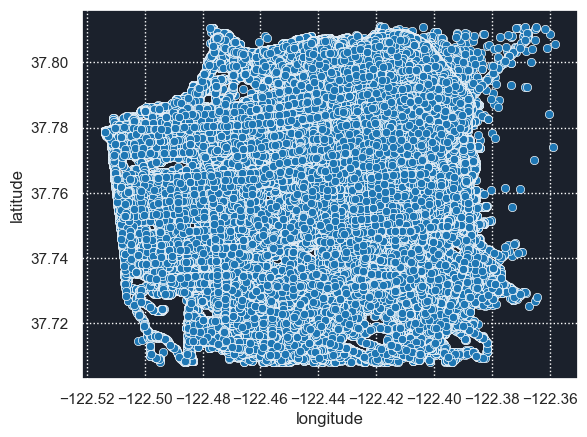

In [34]:
sns.scatterplot(x=valid_df['longitude'], y=valid_df['latitude'])

Datapoints look cleaner now. The valid events datasets is saved to further scale and analyze the datapoints deeper.

In [35]:
valid_df.to_csv(data_path+'valid_df.csv')
del valid_df
gc.collect()

7639558

## Distance Analysis
***

In [36]:
df =  pd.read_csv(data_path+'valid_df.csv', index_col=0)
df['time']= pd.to_datetime(df['time'])
df.tail()

,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration
11220053,uvreoipy_1213035491,uvreoipy,37.74654,-122.44338,2008-06-09 18:18:11,1,uvreoipy_1213035433,1.863837,296.0
11220054,uvreoipy_1213035548,uvreoipy,37.75140,-122.44296,2008-06-09 18:19:08,1,uvreoipy_1213035433,1.863837,296.0
11220055,uvreoipy_1213035612,uvreoipy,37.75686,-122.44239,2008-06-09 18:20:12,1,uvreoipy_1213035433,1.863837,296.0
11220056,uvreoipy_1213035668,uvreoipy,37.76047,-122.44215,2008-06-09 18:21:08,1,uvreoipy_1213035433,1.863837,296.0
11220057,uvreoipy_1213035729,uvreoipy,37.76075,-122.43687,2008-06-09 18:22:09,1,uvreoipy_1213035433,1.863837,296.0


In [37]:
distance_df = (df[['id_event', 'travelled_distance_km']]
                     .groupby(['id_event'])
                     .travelled_distance_km
                     .first()
                     .to_frame())
distance_df.head()

,travelled_distance_km
id_event,
abboip_1211033530,0.301731
abboip_1211035870,1.639782
abboip_1211036160,0.815618
abboip_1211037710,2.485586
abboip_1211041120,4.382149


In [38]:
print(f'Max travelled distance of empty cab (km): {df[df.occupancy == 0.0].travelled_distance_km.max()}')
print(f'Median travelled distance of empty cab (km): {df[df.occupancy == 0.0].travelled_distance_km.median()}')
print(f'Average travelled distance of empty cab (km): {df[df.occupancy == 0.0].travelled_distance_km.mean()}')
print(f'Min travelled distance of empty cab (km): {df[df.occupancy == 0.0].travelled_distance_km.min()}')
print('')
print(f'Max travelled distance of cab with passengers (km): {df[df.occupancy == 1.0].travelled_distance_km.max()}')
print(f'Median travelled distance cab with passengers (km): {df[df.occupancy == 1.0].travelled_distance_km.median()}')
print(f'Average travelled distance cab with passengers (km): {df[df.occupancy == 1.0].travelled_distance_km.mean()}')
print(f'Min travelled distance with passengers (km): {df[df.occupancy == 1.0].travelled_distance_km.min()}')

Max travelled distance of empty cab (km): 11.981891810222718
Median travelled distance of empty cab (km): 1.6065360776412372
Average travelled distance of empty cab (km): 2.0647096132468588
Min travelled distance of empty cab (km): 0.0

Max travelled distance of cab with passengers (km): 12.187745184962235
Median travelled distance cab with passengers (km): 2.7343380309790577
Average travelled distance cab with passengers (km): 3.1306351685983396
Min travelled distance with passengers (km): 0.0


<AxesSubplot:title={'center':'Occupied Cab Events'}, xlabel='travelled_distance_km', ylabel='Count'>

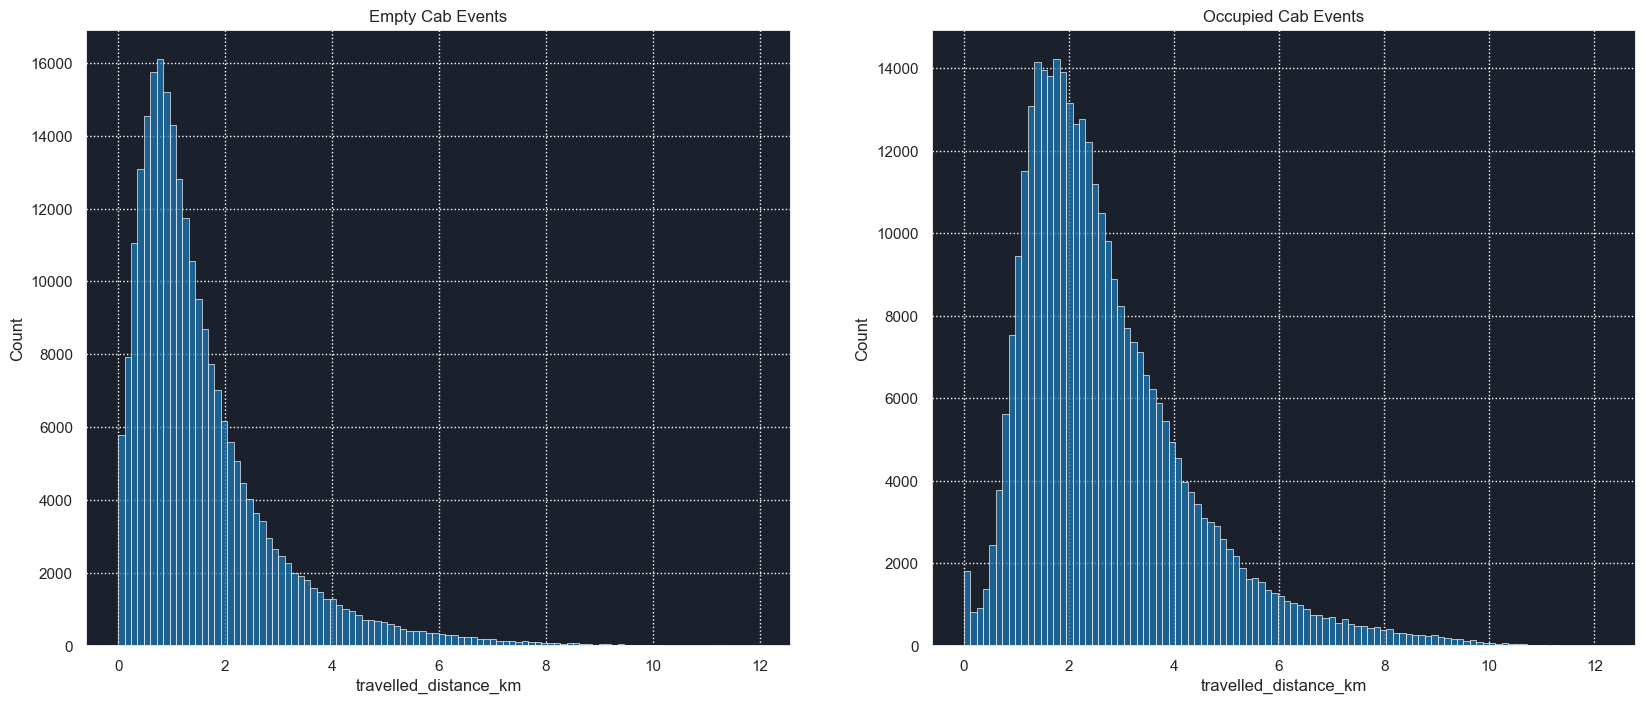

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].set_title('Empty Cab Events')
empty_cab_df = df[df.occupancy == 0]
empty_cab_distance_df = empty_cab_df.groupby('travelled_distance_km').event_duration.first().to_frame()
sns.histplot(data=empty_cab_distance_df, x='travelled_distance_km', bins=100, ax=axs[0])

axs[1].set_title('Occupied Cab Events')
occupied_cab_df = df[df.occupancy == 1]
empty_cab_distance_df = occupied_cab_df.groupby('travelled_distance_km').event_duration.first().to_frame()
sns.histplot(data=empty_cab_distance_df, x='travelled_distance_km', bins=100, ax=axs[1])

Because the location limits have been set and filtered the dispersion is usual.  
One noteworthy point is that occupied cabs have a meaningful amount of zero km. distance travelled, that is a clear outlier.
A further analysis on the occupied cab events should be done.

In [40]:
# occupied cab travelled distance quantiles
(occupied_cab_df[['id_event', 'travelled_distance_km']]
 .quantile(q=percentiles, axis=0, numeric_only=True, interpolation='linear')).T

,0.05,0.10,0.25,0.50,0.75,0.90,0.95,1.00
travelled_distance_km,0.924544,1.222561,1.816131,2.734338,4.034267,5.606519,6.787285,12.187745


From the quantiles analysis of occupied cabs travelled distance in km. a lower limit of the 5% quantiles value is used.  
💡 Assumption - Occupied cabs that travel less than 0.92 km are outliers (non-inlcusive)

In [41]:
distance_outlier_event_ids = occupied_cab_df[occupied_cab_df['travelled_distance_km'] < 0.924544].id_event.unique()

In [42]:
valid_distance_ids_count = len(df.id_event.unique()) - len(distance_outlier_event_ids)
print(f'The number of valid distance fares is {valid_distance_ids_count}')
print(f'The number of non valid distance fares is {len(distance_outlier_event_ids)}')
print(f'The total number of fares is {len(df.id_event.unique())}')

The number of valid distance fares is 565780
The number of non valid distance fares is 21046
The total number of fares is 586826


In [43]:
filtered_distance_df = df[~df.id_event.isin(distance_outlier_event_ids)]

In [44]:
filtered_distance_df[filtered_distance_df['occupancy']==1].describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,3372787.0,37.781873,0.015697,37.708100,37.773820,37.785350,37.792160,37.810960
longitude,3372787.0,-122.421274,0.018992,-122.513860,-122.429710,-122.419110,-122.407940,-122.357960
occupancy,3372787.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
travelled_distance_km,3372787.0,3.265772,1.769316,0.924544,1.950274,2.836852,4.122953,12.187745
event_duration,3372787.0,706.775942,319.822301,242.000000,470.000000,643.000000,874.000000,2039.000000


<AxesSubplot:title={'center':'Occupied Cab Events'}, xlabel='travelled_distance_km', ylabel='Count'>

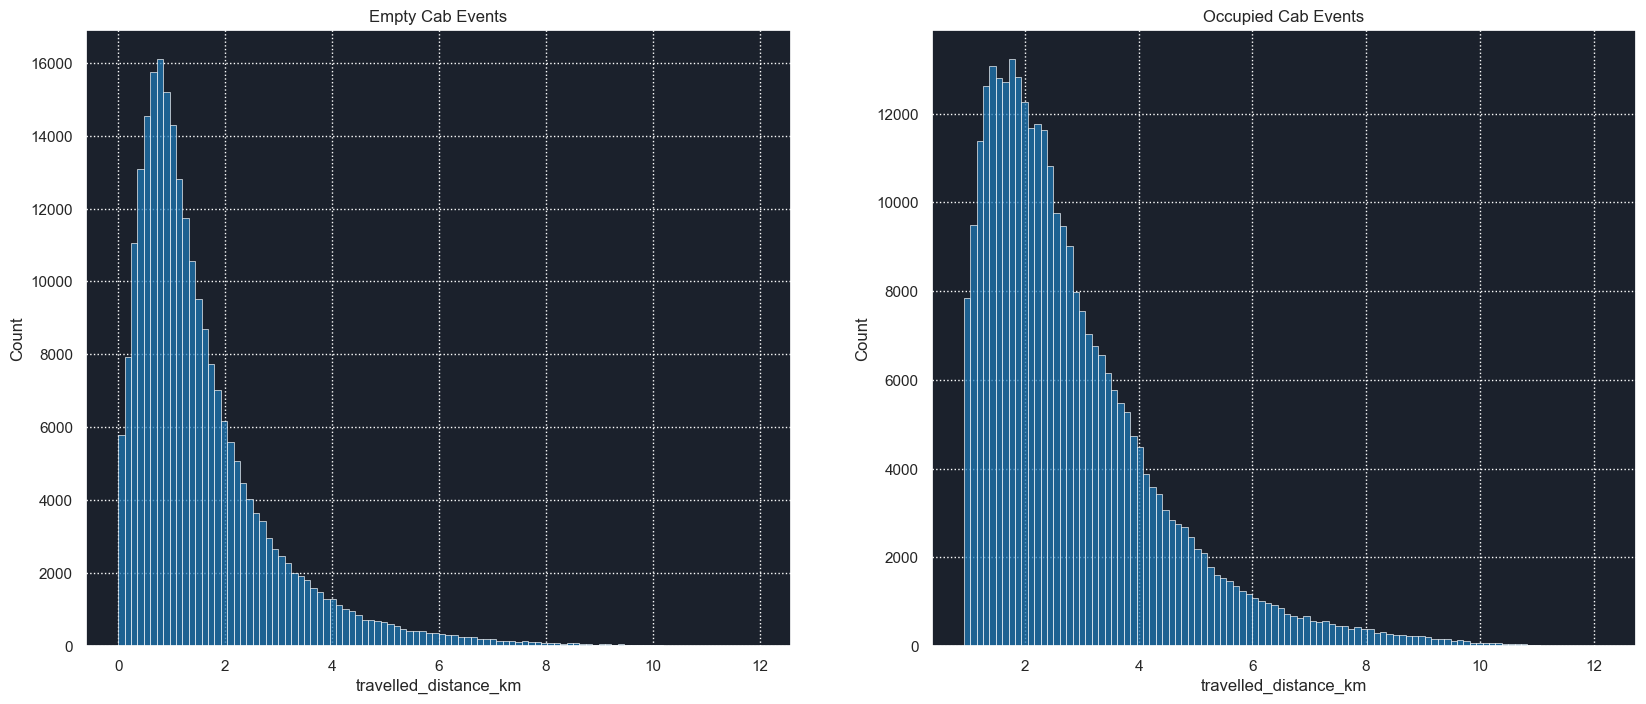

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

axs[0].set_title('Empty Cab Events')
empty_cab_df = filtered_distance_df[filtered_distance_df.occupancy == 0]
empty_cab_distance_df = empty_cab_df.groupby('travelled_distance_km').event_duration.first().to_frame()
sns.histplot(data=empty_cab_distance_df, x='travelled_distance_km', bins=100, ax=axs[0])

axs[1].set_title('Occupied Cab Events')
occupied_cab_df = filtered_distance_df[filtered_distance_df.occupancy == 1]
empty_cab_distance_df = occupied_cab_df.groupby('travelled_distance_km').event_duration.first().to_frame()
sns.histplot(data=empty_cab_distance_df, x='travelled_distance_km', bins=100, ax=axs[1])

In [46]:
print(f'Max travelled distance of empty cab (km): {filtered_distance_df[filtered_distance_df.occupancy == 0.0].travelled_distance_km.max()}')
print(f'Median travelled distance of empty cab (km): {filtered_distance_df[filtered_distance_df.occupancy == 0.0].travelled_distance_km.median()}')
print(f'Average travelled distance of empty cab (km): {filtered_distance_df[filtered_distance_df.occupancy == 0.0].travelled_distance_km.mean()}')
print(f'Min travelled distance of empty cab (km): {filtered_distance_df[filtered_distance_df.occupancy == 0.0].travelled_distance_km.min()}')
print('')
print(f'Max travelled distance of cab with passengers (km): {filtered_distance_df[filtered_distance_df.occupancy == 1.0].travelled_distance_km.max()}')
print(f'Median travelled distance cab with passengers (km): {filtered_distance_df[filtered_distance_df.occupancy == 1.0].travelled_distance_km.median()}')
print(f'Average travelled distance cab with passengers (km): {filtered_distance_df[filtered_distance_df.occupancy == 1.0].travelled_distance_km.mean()}')
print(f'Min travelled distance with passengers (km): {filtered_distance_df[filtered_distance_df.occupancy == 1.0].travelled_distance_km.min()}')

Max travelled distance of empty cab (km): 11.981891810222718
Median travelled distance of empty cab (km): 1.6065360776412372
Average travelled distance of empty cab (km): 2.0647096132468588
Min travelled distance of empty cab (km): 0.0

Max travelled distance of cab with passengers (km): 12.187745184962235
Median travelled distance cab with passengers (km): 2.8368522552697253
Average travelled distance cab with passengers (km): 3.265772256737369
Min travelled distance with passengers (km): 0.9245444196319564


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

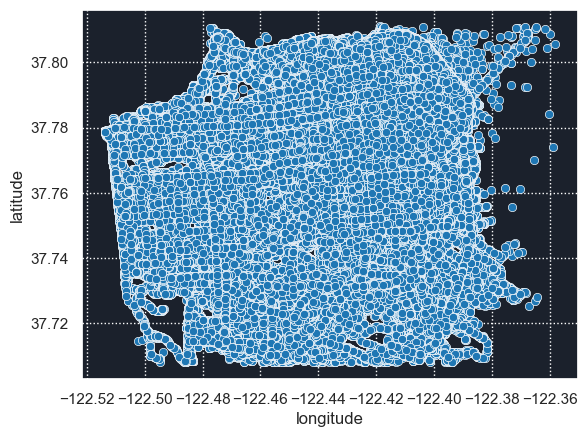

In [47]:
sns.scatterplot(x=filtered_distance_df['longitude'], y=filtered_distance_df['latitude'])

In [48]:
filtered_distance_df.to_csv(data_path+'clean_cabspotting_df.csv')
del filtered_distance_df
gc.collect()

261

### CO2 Savings
***

**Calculate potential yearly reduction in CO2 emissions of cabs without passengers**

Since only about 24 days of data was collected between May 17th 2008 and June 10 2008 and the scope of the analysis is focused on a month's worth of information, the data must be scaled to fit into the expected time frame (one month).

Additionally,for simplicity's sake, no variability or seasonality is taken into account.


⚙️ Specification - Average passenger vehicle emits about 404 grams of CO2 per mile.  
⚙️ Specification - Taxicab fleet change rate of 15% per month (from combustion engine-powered vehicles to electric vehicles).  
⚙️ Specification - No seasonality or distance variability is scoped into this analysis

In [49]:
df =  pd.read_csv(data_path+'clean_cabspotting_df.csv', index_col=0)
df['time']= pd.to_datetime(df['time'])
print(f"There are {len(df.id_event.unique())} unique event ids")
df.tail()

There are 565780 unique event ids


,id,file_name,latitude,longitude,time,occupancy,id_event,travelled_distance_km,event_duration
11220053,uvreoipy_1213035491,uvreoipy,37.74654,-122.44338,2008-06-09 18:18:11,1,uvreoipy_1213035433,1.863837,296.0
11220054,uvreoipy_1213035548,uvreoipy,37.75140,-122.44296,2008-06-09 18:19:08,1,uvreoipy_1213035433,1.863837,296.0
11220055,uvreoipy_1213035612,uvreoipy,37.75686,-122.44239,2008-06-09 18:20:12,1,uvreoipy_1213035433,1.863837,296.0
11220056,uvreoipy_1213035668,uvreoipy,37.76047,-122.44215,2008-06-09 18:21:08,1,uvreoipy_1213035433,1.863837,296.0
11220057,uvreoipy_1213035729,uvreoipy,37.76075,-122.43687,2008-06-09 18:22:09,1,uvreoipy_1213035433,1.863837,296.0


In [50]:
# Only cab fares without passengers should be considered.
empty_cabs_df = df[df['occupancy']==0]
empty_cabs_df.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,3345632.0,37.781450,0.017026,37.70810,37.773120,37.786020,37.792230,37.810860
longitude,3345632.0,-122.419423,0.020733,-122.51391,-122.429740,-122.415160,-122.404820,-122.358680
occupancy,3345632.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
travelled_distance_km,3345632.0,2.064710,1.661166,0.00000,0.879689,1.606536,2.767496,11.981892
event_duration,3345632.0,1396.756764,1123.037963,179.00000,544.000000,1024.000000,1913.000000,5089.000000


In [51]:
# CO2 grams per mile:
co2_per_mile = 404

# monthly fleet conversion rate of engine to electric fleet vehicles:
converstion_rate_combustion_to_electric = 0.15

In [52]:
# drop unused columns for smoother computation
columns_to_drop = ['id', 'file_name', 'latitude', 'longitude', 'occupancy', 'time', 'event_duration']

# keep unique values in the 'id_event' table
empty_cabs_unique_events_df = empty_cabs_df.drop_duplicates('id_event').reset_index(drop=True)
empty_cabs_unique_events_df.drop(columns_to_drop, axis=1, inplace=True)

In [53]:
empty_cabs_unique_events_df.head()

,id_event,travelled_distance_km
0,abboip_1211033530,0.301731
1,abboip_1211036160,0.815618
2,abboip_1211037710,2.485586
3,abboip_1211042074,1.706602
4,abboip_1211045370,1.134740


In [54]:
# how much distance was travelled by empty cab fares
total_empty_cab_travelled_distance = empty_cabs_unique_events_df.travelled_distance_km.sum()
print(f'{int(total_empty_cab_travelled_distance)}km '
      + 'have been travelled by cabs without passengers during the timeframe of collected info (2071530sec)')

394141km have been travelled by cabs without passengers during the timeframe of collected info (2071530sec)


In [55]:
seconds_in_day = 60*60*24

# travelled distance of empty cabs in km per second
total_travelled_distance_km_of_emtpy_cabs_per_sec = total_empty_cab_travelled_distance / 2071530

# average days in a month accounting for leap year
avg_days_in_month = ((3*365) + 366) / (12*4)

# total distance of empty cabs travelled in an average month duration
total_empty_cab_travelled_distance_in_month = (
    total_travelled_distance_km_of_emtpy_cabs_per_sec
    *seconds_in_day
    *avg_days_in_month
)

print('The total travelled distance of empty cabs ' + 
      f'in a month is: {np.ceil(total_empty_cab_travelled_distance_in_month)}km')

The total travelled distance of empty cabs in a month is: 500361.0km


Since the usecase asks for potential yearly reduction based on the premise that 15% of combustion engine fleet is replaced by electrical vehicles a yearly travelled distance must be calculated taking into account the replacements.  
💡 Assumption - Conversion distance starts from the very first month

In [56]:
## Recursive
# aliases for leaner code
tdpm = total_empty_cab_travelled_distance_in_month # 500361.0km
cr = converstion_rate_combustion_to_electric

monthly_combustion_distance_km = list()
cum_monthly_combustion_distance_km = list()

monthly_electric_distance_km = list()
cum_monthly_electric_distance_km = list()

monthly_total_km = list()
cum_monthly_total_km = list()

remaining_combustion_engine_distance = list()

comb_cars=list()

ecars=list()
cum_ecars=list()


for i in range(12): 
    tdpm = tdpm+(tdpm*(random.randint(-10,10)*0.01))
    if i == 0:
        #monthly_combustion_distance_km.append(tdpm*(1-cr))
        monthly_combustion_distance_km.append(tdpm)
        cum_monthly_combustion_distance_km.append(sum(monthly_combustion_distance_km))
        
        monthly_electric_distance_km.append(tdpm * cr)
        #cum_monthly_electric_distance_km.append(sum(monthly_electric_distance_km))
        cum_monthly_electric_distance_km.append(tdpm * cr)
        
        monthly_total_km.append(tdpm)
        cum_monthly_total_km.append(sum(cum_monthly_total_km))
        
        comb_cars.append(math.floor(537 * (1 - cr)))
        
        ecars.append(math.ceil(537 * cr))
        cum_ecars.append(sum(ecars))
        
        #remaining_combustion_engine_distance.append(tdpm)
        remaining_combustion_engine_distance.append(monthly_combustion_distance_km[i]-monthly_electric_distance_km[i])
        
    # for every other step, calculate it considering the new ev and gas distances:
    else:
        #monthly_combustion_distance_km.append(monthly_combustion_distance_km[i-1] * (1 - cr))
        monthly_combustion_distance_km.append(tdpm - sum(monthly_electric_distance_km))
        cum_monthly_combustion_distance_km.append(sum(monthly_combustion_distance_km))
        
        #monthly_electric_distance_km.append(monthly_combustion_distance_km[i-1] * cr + monthly_electric_distance_km[i-1])
        monthly_electric_distance_km.append(monthly_combustion_distance_km[i]*cr)
        cum_monthly_electric_distance_km.append(sum(monthly_electric_distance_km))
        
        monthly_total_km.append(tdpm)
        cum_monthly_total_km.append(sum(monthly_total_km))
        
        comb_cars.append(math.floor(comb_cars[i-1] * (1 - cr)))
        
        ecars.append(math.ceil(comb_cars[i-1] * cr))
        cum_ecars.append(sum(ecars))
        
        #remaining_combustion_engine_distance.append(monthly_combustion_distance_km[i])
        remaining_combustion_engine_distance.append(monthly_combustion_distance_km[i]-monthly_electric_distance_km[i])
            
        

co2_savings_kg = np.asarray(monthly_electric_distance_km) * co2_per_mile / 1000       
cum_co2_savings_kg = np.asarray(cum_monthly_electric_distance_km) * co2_per_mile / 1000    

In [57]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df1 = pd.DataFrame({
    'months': range(1,13),
    'combustion_distance': monthly_combustion_distance_km,
    'cum_combustion_distance': cum_monthly_combustion_distance_km,
    'electric_distance': monthly_electric_distance_km,
    'cum_electric_distance': cum_monthly_electric_distance_km,
    'total_monthly_distance': monthly_total_km,
    'cum_monthly_km': cum_monthly_total_km,
    'remaining_combustion_engine_distance': remaining_combustion_engine_distance,
    'co2_savings_kg': co2_savings_kg,
    'cum_co2_savings_kg': cum_co2_savings_kg,
    'comb_cars': comb_cars,
    'ecars': ecars,
    'cum_ecars': cum_ecars
    
})
df1.round(2)

,months,combustion_distance,cum_combustion_distance,electric_distance,cum_electric_distance,total_monthly_distance,cum_monthly_km,remaining_combustion_engine_distance,co2_savings_kg,cum_co2_savings_kg,comb_cars,ecars,cum_ecars
0,1,475342.86,475342.86,71301.43,71301.43,475342.86,0.00,404041.43,28805.78,28805.78,456,81,81
1,2,356507.15,831850.01,53476.07,124777.50,427808.58,903151.44,303031.08,21604.33,50410.11,387,69,150
2,3,315865.33,1147715.34,47379.80,172157.30,440642.83,1343794.27,268485.53,19141.44,69551.55,328,59,209
3,4,272891.96,1420607.30,40933.79,213091.10,445049.26,1788843.54,231958.17,16537.25,86088.80,278,50,259
4,5,196354.23,1616961.53,29453.13,242544.23,409445.32,2198288.86,166901.09,11899.07,97987.87,236,42,301
5,6,195562.26,1812523.79,29334.34,271878.57,438106.49,2636395.35,166227.92,11851.07,109838.94,200,36,337
6,7,183752.18,1996275.98,27562.83,299441.40,455630.75,3092026.11,156189.36,11135.38,120974.32,170,30,367
7,8,119738.90,2116014.88,17960.83,317402.23,419180.29,3511206.40,101778.06,7256.18,128230.50,144,26,393
8,9,110161.67,2226176.54,16524.25,333926.48,427563.90,3938770.30,93637.42,6675.80,134906.30,122,22,415
9,10,93637.42,2319813.96,14045.61,347972.09,427563.90,4366334.20,79591.81,5674.43,140580.73,103,19,434


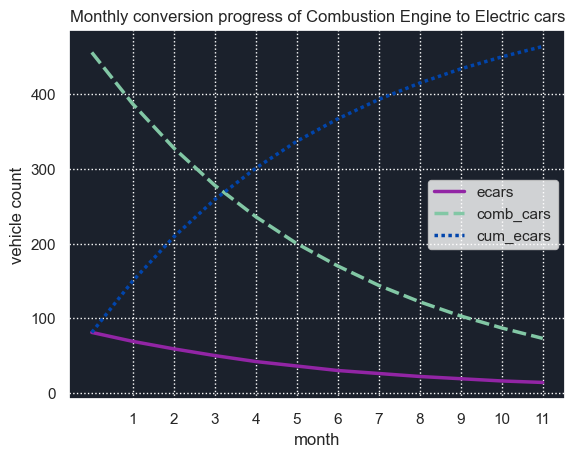

In [58]:
sns.lineplot(data=df1[['ecars', 'comb_cars', 'cum_ecars']], palette=sns.color_palette(flatui[:3]))
plt.title('Monthly conversion progress of Combustion Engine to Electric cars')
plt.legend().get_frame().set_facecolor('white')
plt.ylabel("vehicle count")
plt.xlabel("month")
plt.xticks(range(1,12))
plt.show()

In [59]:
print(f'Total potential savings in kg of CO2 per year: {round(df1.cum_co2_savings_kg.sum(), 2)}')

Total potential savings in kg of CO2 per year: 1258582.65


NameError: name 'ax2' is not defined

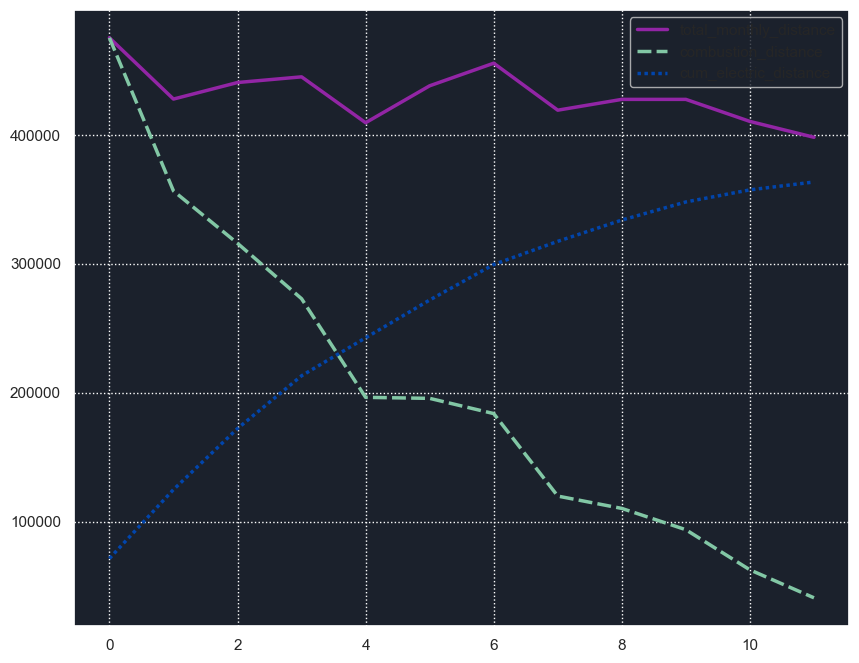

In [60]:
fig, ax1 = plt.subplots(figsize=(10, 8)) 
sns.lineplot(data=df1[['total_monthly_distance', 'combustion_distance', 'cum_electric_distance']], palette=sns.color_palette(flatui[:3]), linewidth=2.5, ax=ax1)
sns.lineplot(data=df1[['cum_co2_savings_kg']], palette='dark', ax=ax2)
plt.grid(False)
plt.legend(loc='lower center').get_frame().set_facecolor('white')
plt.xlabel('Months')
plt.ylabel('Distance in km')
plt.title('Monthly travelled distance by combustion engine and electric vehicles')
plt.show()

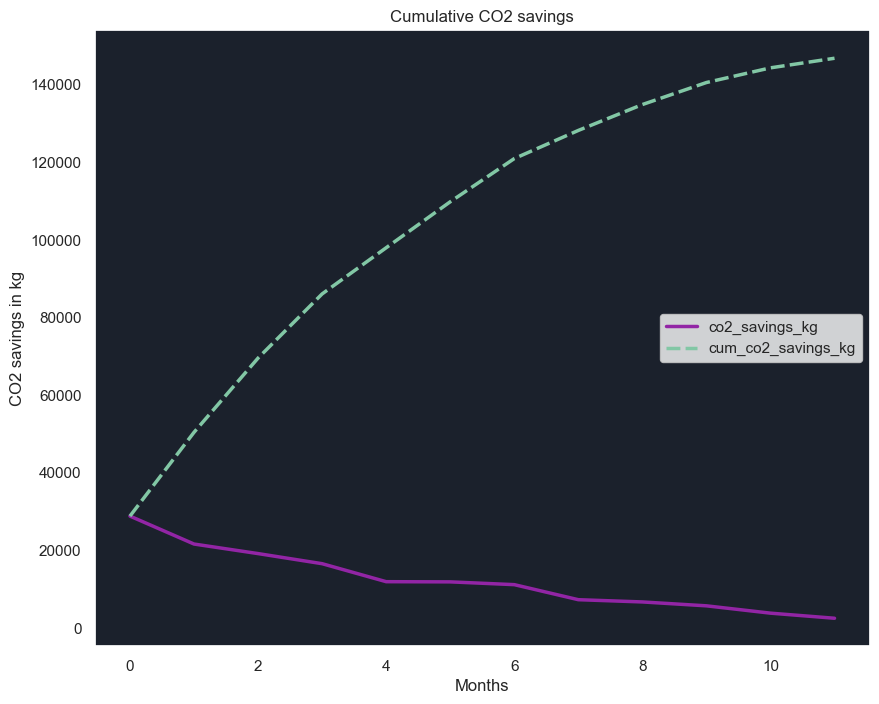

In [61]:
fig, ax1 = plt.subplots(figsize=(10, 8)) 
sns.lineplot(data=df1[['co2_savings_kg','cum_co2_savings_kg']], palette=sns.color_palette(flatui[:2]))
plt.grid(False)
plt.legend(loc='center right').get_frame().set_facecolor('white')
plt.xlabel('Months')
plt.ylabel('CO2 savings in kg')
plt.title('Cumulative CO2 savings')
plt.show()

In [62]:
print(f'Total potential savings in kg of CO2 per year: {round(df1.cum_co2_savings_kg.sum(), 2)}')

Total potential savings in kg of CO2 per year: 1258582.65


Since we have a CO2 per mile assumption, km are converted to miles to get the Yearly CO2 savings

#### Given the before mentioned specifications, assumptions and scopes it is concluded that the amount of  
#### potential yearly CO2 saving given a 15% replacement fleet rate of combustion engine vehicles to electrical vehicles  
#### is an approximate of 1557 Metric Tons of CO2